## Load Python Libraries

Run the below code to import the required python libraries

In [85]:
#Import Libraries
%matplotlib inline

import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import join, expanduser

import matplotlib
import matplotlib.pyplot as plt

from scipy import stats

from neon_utils import download_eval_files

## Open model data files

Since our default run was a run till present, it has more than 36 months of output data. Therefore, we need to establish a way that reads data for 2018 to 2020 december. We are going to read the vcmax_min and vcmax_max output data directly as we did the run for only 36 months.

Here we use the python function xarray.open_mfdataset, which opens multiple netcdf files as a single xarray dataset. For more information on this xarray function, visit the xarray website.

Run the below cell to read in the data files. Note that this step might take a few minutes.

In [86]:
#Reading specific years within the default run folder
start = time.time()
neon_site = "TALL"
years = ["2018", "2019", "2020"]
df_path = os.path.join('/home/user/archive/'+neon_site+'.transient/lnd/hist/')

df_files = []
for year in years:
    df_file = join(df_path, 'TALL.transient.clm2.h0.'+year+'*.nc')
    df_files += glob(df_file)

ds_ctsm_def = xr.open_mfdataset(df_files, decode_times=True, combine='by_coords')

end = time.time()
print("Reading all default run files took:", end-start, "s.")

Reading all default run files took: 23.726773977279663 s.


In [87]:
# Now we shall read our modified parameter model data
# Remember the model prints both daily and monthly output files. We shall read the monthly output files "H0".
# If you are interested in daily outputs, you can use "h1" in the cell below instead of "h0"
ds_ctsm_vmin = xr.open_mfdataset("/home/user/archive/TALLvcmax_min/lnd/hist/TALLvcmax_min.clm2.h0.*.nc")
ds_ctsm_vmax = xr.open_mfdataset("/home/user/archive/TALLvcmax_max/lnd/hist/TALLvcmax_max.clm2.h0.*.nc")

## Downloading NEON data

If you already downloaded the data, you can skip running the cell below.

In [ ]:
eval_dir = "/home/user/evaluation_files/"
download_eval_files(neon_site, eval_dir, "all")

## Load NEON data

Again, we downloaded all available neon data and we only need to extract data for 2018 to 2020, so we shall create a script to only read data for those specifi years. The code below does that and can be modified to read whatever years of data you have.

In [ ]:
start = time.time()
years = ["2018", "2019", "2020"]
eval_path = os.path.join('/home/user/evaluation_files/', neon_site)

eval_files = []
for year in years:
    eval_file = join(eval_path, neon_site + "_eval_" + year + "*.nc")
    eval_files += glob(eval_file)

eval_files = sorted(eval_files)

print("All Observation files:")
print(*eval_files, sep='\n')

ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords')

end = time.time()
print("Reading all observation files took:", end-start, "s.")

## Reading NEON Data and extracting for monthly

The following script will help us read NEON data in monthly time steps for easy handling with the model we created.

In [90]:
eval_vars = ['EFLX_LH_TOT', 'GPP']
df_eval = pd.DataFrame({'time':ds_eval.time})
for var in eval_vars:
    field = np.ravel(ds_eval[var])
    df_eval[var] = field
#print("All Observation files:")
#print(*eval_files,sep='\n')
df_eval['time'] = pd.to_datetime(df_eval['time'],format='%Y%m%d %H:%M')
df_eval['year'] = pd.DatetimeIndex(df_eval['time']).year
df_eval['month'] = pd.DatetimeIndex(df_eval['time']).month
df_eval['day'] = pd.DatetimeIndex(df_eval['time']).day
df_eval['hour'] = pd.DatetimeIndex(df_eval['time']).hour
#-- extract year, month, day, hour information from time
df_eval['year'] = df_eval['time'].dt.year
df_eval['month'] = df_eval['time'].dt.month
df_eval['day'] = df_eval['time'].dt.day
df_eval['hour'] = df_eval['time'].dt.hour

df_monthly = df_eval.groupby(['year','month']).mean().reset_index()
df_monthly["day"]=1
df_monthly['time']=pd.to_datetime(df_monthly[["year", "month","day"]])

df_eva = df_monthly
ds_eva = df_eva.set_index('time').to_xarray()

/tmp/ipykernel_91/79114352.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_monthly = df_eval.groupby(['year','month']).mean().reset_index()


In [91]:
#Convert CTSM data to a Pandas Dataframe for easier handling:
ctsm_vars = ['FCEV', 'FCTR', 'FGEV','GPP']

df_ctsm = pd.DataFrame({'time':ds_ctsm_def.time})

for var in ctsm_vars:
    field = np.ravel ( ds_ctsm_def[var])     
    df_ctsm[var]=field

df_ctsm_vmin = pd.DataFrame({'time':ds_ctsm_vmin.time})

for var in ctsm_vars:
    field = np.ravel ( ds_ctsm_vmin[var])     
    df_ctsm_vmin[var]=field

df_ctsm_vmax = pd.DataFrame({'time':ds_ctsm_vmax.time})

for var in ctsm_vars:
    field = np.ravel ( ds_ctsm_vmax[var])     
    df_ctsm_vmax[var]=field

#Convert NEON data to a Pandas Dataframe for easier handling:
eval_vars = ['EFLX_LH_TOT','GPP']

df_eval = pd.DataFrame({'time':ds_eva.time})

for var in eval_vars:
    field = np.ravel ( ds_eva[var])     
    df_eval[var]=field

#-- make df_all that includes both obs and sim
df_all = df_eval

#-- add simulation data to df_all and adjust for offset time dimension:
for var in ctsm_vars:
    sim_var_name = "def_"+var
    #-- shift simulation data by one
    df_all[sim_var_name]=df_ctsm[var].shift(-1).values

for var in ctsm_vars:
    sim_var_name1 = "vmin_"+var
    #-- shift simulation data by one
    df_all[sim_var_name1]=df_ctsm_vmin[var].shift(-1).values
    
for var in ctsm_vars:
    sim_var_name2 = "vmax_"+var
    #-- shift simulation data by one
    df_all[sim_var_name2]=df_ctsm_vmax[var].shift(-1).values

## Preparing and doing some conversion so that both the simulated and the observed data can be compared.

In [92]:
df_all = df_all.fillna(0)    
clm_var = 'def_EFLX_LH_TOT'

#EFLX_LH_TOT = FCEV + FCTR +FGEV
df_all [clm_var] = df_all['def_FCEV'] \
                 + df_all['def_FCTR']\
                 + df_all['def_FGEV']

#Convert simulated GPP from gC to Umol Carbon
df_all ['def_GPP'] = df_all['def_GPP'] * 83333.3

clm_var1 = 'vmin_EFLX_LH_TOT'

#EFLX_LH_TOT = FCEV + FCTR +FGEV
df_all [clm_var1] = df_all['vmin_FCEV'] \
                 + df_all['vmin_FCTR']\
                 + df_all['vmin_FGEV']

#Convert simulated GPP from gC to Umol Carbon
df_all ['vmin_GPP'] = df_all['vmin_GPP'] * 83333.3

clm_var2 = 'vmax_EFLX_LH_TOT'

#EFLX_LH_TOT = FCEV + FCTR +FGEV
df_all [clm_var2] = df_all['vmax_FCEV'] \
                 + df_all['vmax_FCTR']\
                 + df_all['vmax_FGEV']

#Convert simulated GPP from gC to Umol Carbon
df_all ['vmax_GPP'] = df_all['vmax_GPP'] * 83333.3

df_allm = df_all.loc[:, ['EFLX_LH_TOT','GPP','def_EFLX_LH_TOT','def_GPP','vmin_EFLX_LH_TOT',
             'vmin_GPP','vmax_EFLX_LH_TOT','vmax_GPP']]
df_allm.head()

,EFLX_LH_TOT,GPP,def_EFLX_LH_TOT,def_GPP,vmin_EFLX_LH_TOT,vmin_GPP,vmax_EFLX_LH_TOT,vmax_GPP
0,14.426429,0.858566,34.834721,5.060186,29.826712,4.790771,24.106686,2.968581
1,19.488155,0.781126,46.173672,6.512357,42.456928,6.206745,28.550226,3.384097
2,36.619230,2.214720,64.151596,8.415462,61.765476,8.134331,50.967098,5.805521
3,59.871329,3.677490,80.863167,9.158338,72.180428,8.334477,87.417549,9.741815
4,87.052753,6.652539,79.194702,9.080414,69.892166,7.870697,94.802467,10.380062


## Visualizing the Latent Heat Flux and GPP

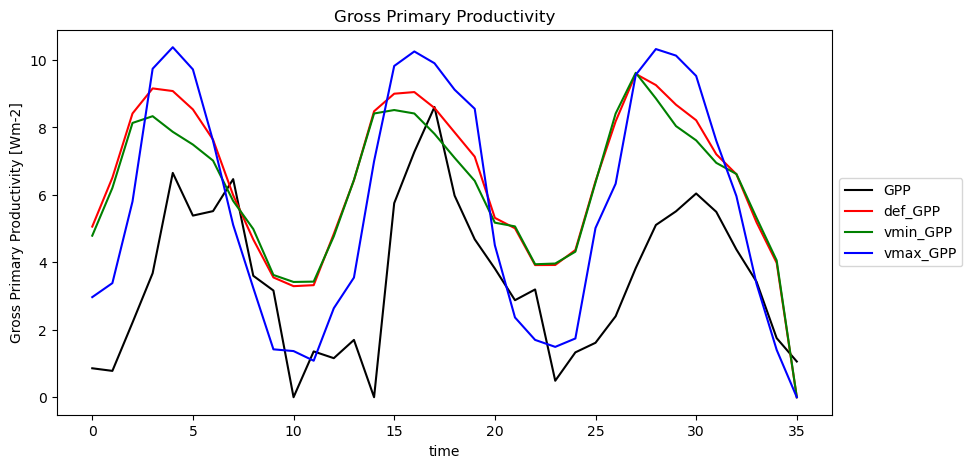

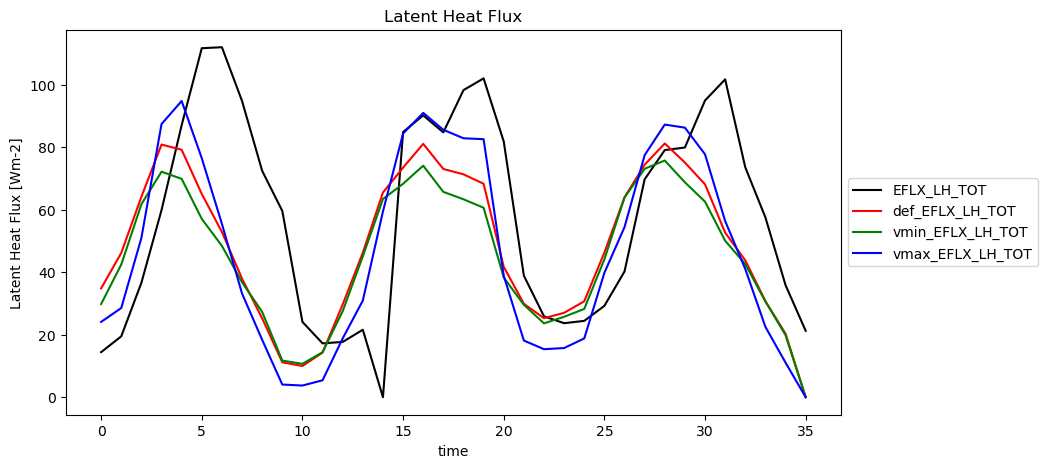

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame called 'df'
gpp_cols = ['GPP', 'def_GPP', 'vmin_GPP', 'vmax_GPP']
eflx_cols = ['EFLX_LH_TOT', 'def_EFLX_LH_TOT', 'vmin_EFLX_LH_TOT', 'vmax_EFLX_LH_TOT']

# Filter the DataFrame to only include the desired columns
gpp_data = df_allm[gpp_cols]
eflx_data = df_allm[eflx_cols]

# Set the index to the time column
#gpp_data.set_index('time', inplace=True)
#eflx_data.set_index('time', inplace=True)

# Create the GPP plot
fig, ax = plt.subplots(figsize=(10, 5))
gpp_data.plot(ax=ax, kind='line', color=['black', 'red', 'green', 'blue'])
ax.set_title('Gross Primary Productivity')
ax.set_xlabel('time')
ax.set_ylabel('Gross Primary Productivity [Wm-2]')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Create the EFLX_LH_TOT plot
fig, ax = plt.subplots(figsize=(10, 5))
eflx_data.plot(ax=ax, kind='line', color=['black', 'red', 'green', 'blue'])
ax.set_title('Latent Heat Flux')
ax.set_xlabel('time')
ax.set_ylabel('Latent Heat Flux [Wm-2]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()